In [4]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import glob
import imageio
imageio.plugins.ffmpeg.download()
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

out_dir='output_images/stage1/'

# load pickled distortion matrix
with open('camera_dist_pickle.p', mode='rb') as f:
    dist_pickle = pickle.load(f)
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]

In [5]:
images = glob.glob('test_images/*.jpg')
# Visualize undistortion on test images

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    image_name=os.path.split(fname)[1]
    write_name = out_dir+'undistorted_'+image_name
    cv2.imwrite(write_name,dst)
    print(write_name)
    cv2.imshow('dst', dst)
    cv2.waitKey(500)
cv2.destroyAllWindows()

output_images/stage1/undistorted_test3.jpg
output_images/stage1/undistorted_test1.jpg
output_images/stage1/undistorted_test6.jpg
output_images/stage1/undistorted_test2.jpg
output_images/stage1/undistorted_test4.jpg
output_images/stage1/undistorted_test5.jpg


In [6]:
def undistort(img):
    result = cv2.undistort(img, mtx, dist, None, mtx)
    return result

def binarize(img, s_thresh=(120, 255), sx_thresh=(20, 255),l_thresh=(40,255)):
    img = np.copy(img)
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    #h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    # sobelx = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255))
    # l_channel_col=np.dstack((l_channel,l_channel, l_channel))
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold saturation channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Threshold lightness
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    channels = 255*np.dstack(( l_binary, sxbinary, s_binary)).astype('uint8')        
    binary = np.zeros_like(sxbinary)
    binary[((l_binary == 1) & (s_binary == 1) | (sxbinary==1))] = 1
    binary = 255*np.dstack((binary,binary,binary)).astype('uint8')            
    return  binary,channels


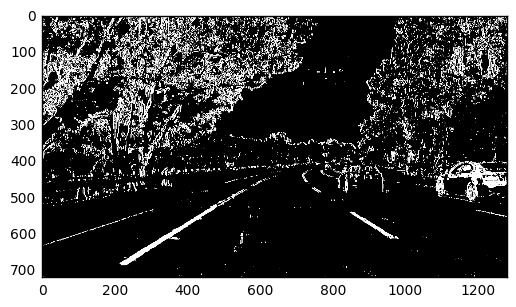

In [8]:
img = plt.imread('test_images/test5.jpg')

shape = img.shape
binary,_ = binarize(img)
plt.imshow(binary)
plt.imsave('binary.jpg',binary)

In [10]:
def warp(img,tobird=True):
    corners = np.float32([[190,720],[589,457],[698,457],[1145,720]])
    new_top_left=np.array([corners[0,0],0])
    new_top_right=np.array([corners[3,0],0])
    offset=[150,0]
    
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([corners[0],corners[1],corners[2],corners[3]])
    dst = np.float32([corners[0]+offset,new_top_left+offset,new_top_right-offset ,corners[3]-offset])    
    if tobird:
        M = cv2.getPerspectiveTransform(src, dst)
    else:
        M = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(img, M, img_size , flags=cv2.INTER_LINEAR)    
    return warped, M

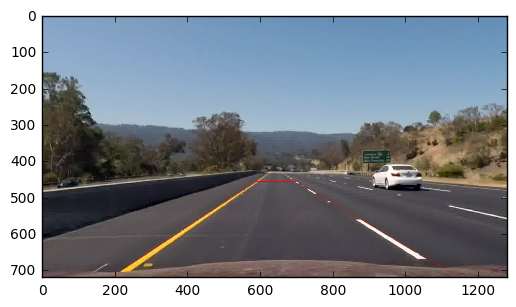

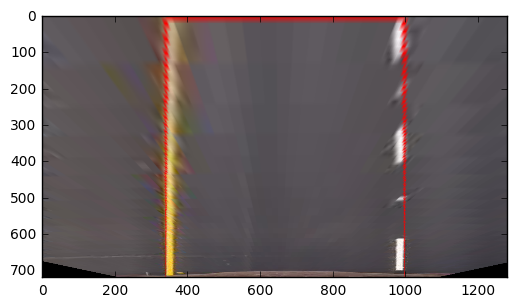

In [20]:
img=plt.imread('./straight_road.jpg')
corners = np.float32([[190,720],[589,457],[698,457],[1145,720]])
img = cv2.undistort(img, mtx, dist, None, mtx)
imshape = img.shape

corner_tuples=[]
for ind,c in enumerate(corners):
    corner_tuples.append(tuple(corners[ind]))

cv2.line(img, corner_tuples[0], corner_tuples[1], color=[255,0,0], thickness=1)
cv2.line(img, corner_tuples[1], corner_tuples[2], color=[255,0,0], thickness=1)
cv2.line(img, corner_tuples[2], corner_tuples[3], color=[255,0,0], thickness=1)
cv2.line(img, corner_tuples[3], corner_tuples[0], color=[255,0,0], thickness=1)
plt.figure()
plt.imshow(img)
plt.imsave('straight_red.jpg',img)
warped,_ = warp(img) 
plt.figure()
plt.imshow(warped)
plt.imsave('straight_red_warped.jpg',warped)

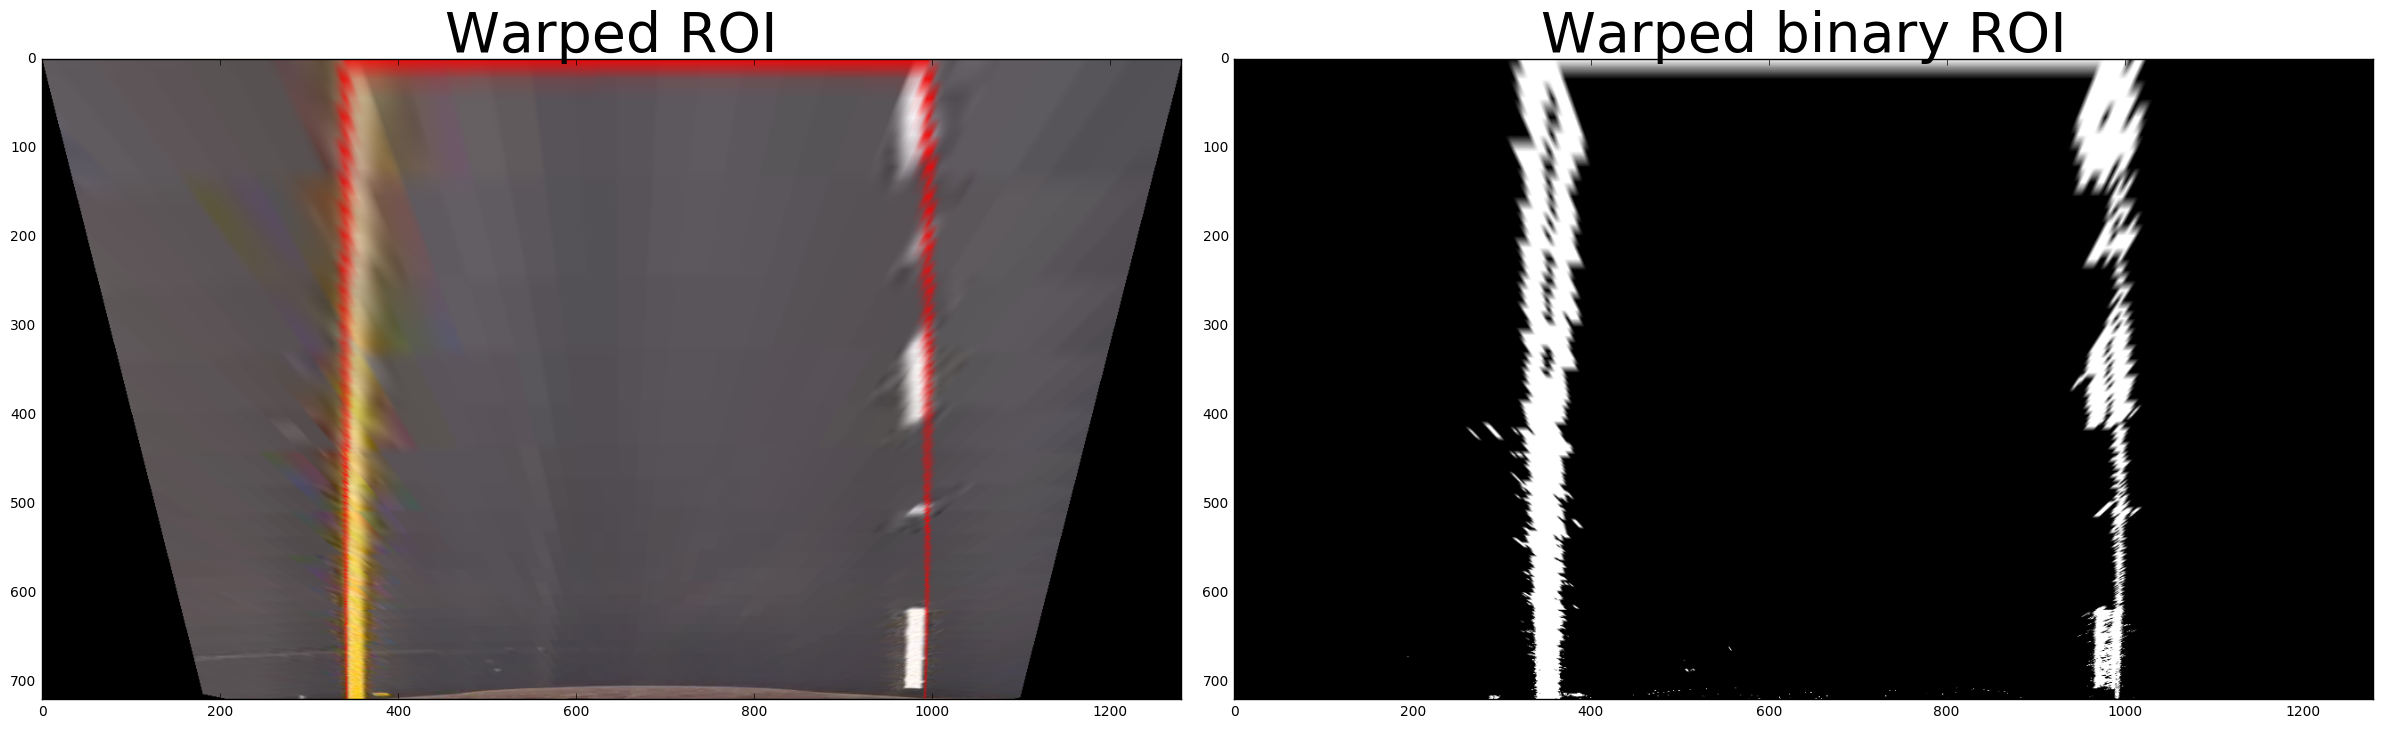

In [26]:
def region_of_interest(img):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """    
    shape = img.shape
    vertices = np.array([[(0,0),(shape[1],0),(shape[1],0),(6*shape[1]/7,shape[0]),
                      (shape[1]/7,shape[0]), (0,0)]],dtype=np.int32)

    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image



def warp_pipeline(img):
    undist = undistort(img)    
    result,_ = warp(undist)
    result = region_of_interest(result)
    return result
    
def warp_binarize_pipeline(img):
    undist = undistort(img)
    binary,_  = binarize(undist)
    result,_  = warp(binary)
    result = region_of_interest(result)
    return result 

warp_roi = warp_pipeline(img)
warp_binary_roi = warp_binarize_pipeline(img)

plt.imsave('warp_roi.jpg',warp_roi)
plt.imsave('warp_binary_roi.jpg',warp_binary_roi)

# Plot the result
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(warp_roi)
ax1.set_title('Warped ROI', fontsize=40)

ax2.imshow(warp_binary_roi)
ax2.set_title('Warped binary ROI', fontsize=40)

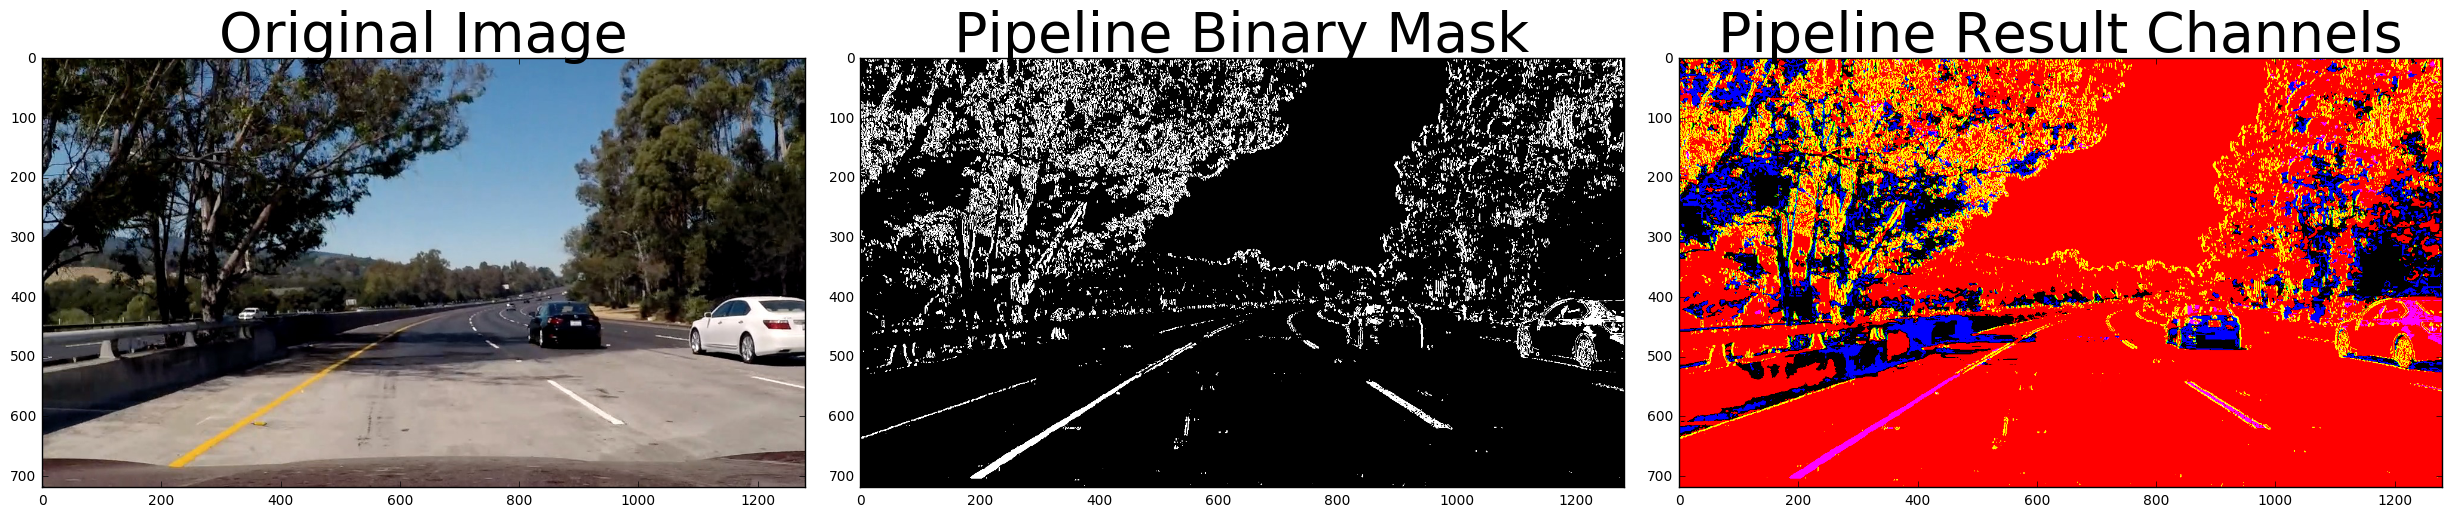

In [10]:
def undistort_image(image):
    result = cv2.undistort(image, mtx, dist, None, mtx)
    return result

def pipeline(img, s_thresh=(160, 255), sx_thresh=(20, 100),l_thresh=(20,255)):
    img = np.copy(img)
    img = undistort_image(img)
    # Convert to HSV color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    #h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    # sobelx = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255))
    # l_channel_col=np.dstack((l_channel,l_channel, l_channel))
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
            
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
        
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Threshold lightness
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    color_binary = 255*np.dstack(( l_binary, sxbinary, s_binary)).astype('uint8')    
    
    combined = np.zeros_like(sxbinary)
    combined[((l_binary == 1) & (s_binary == 1) | (sxbinary==1))] = 1
    color_binary_combined = 255*np.dstack(( combined, combined, combined)).astype('uint8')    
        
    return  color_binary_combined,color_binary
    
image = mpimg.imread('test_images/test5.jpg')    
binary,channels = pipeline(image)

# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(binary)
ax2.set_title('Pipeline Binary Mask', fontsize=40)

ax3.imshow(channels)
ax3.set_title('Pipeline Result Channels', fontsize=40)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [12]:
# Step through the test images and create the binary masks
# Make a list of calibration images
images = glob.glob('test_images/*.jpg')

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    binary,channels = pipeline(img)    
    image_name=os.path.split(fname)[1]
    binary_name = out_dir+'binary_'+image_name
    channels_name = out_dir+'channels_'+image_name
    cv2.imwrite(binary_name,binary)
    cv2.imwrite(channels_name,channels)
    print(fname)
    cv2.imshow('binary', binary)
    cv2.waitKey(500)
cv2.destroyAllWindows()

test_images/test3.jpg
test_images/test1.jpg
test_images/test6.jpg
test_images/solidWhiteRight.jpg
test_images/solidYellowLeft.jpg
test_images/test2.jpg
test_images/test4.jpg
test_images/test5.jpg


In [13]:
def process_image(image):
    binary,channels = pipeline(image)
    return binary

output = out_dir+'stage1_binary_project_video.mp4'
clip = VideoFileClip("project_video.mp4")
binary_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time binary_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_images/stage1/stage1_binary_project_video.mp4
[MoviePy] Writing video output_images/stage1/stage1_binary_project_video.mp4


100%|█████████▉| 1260/1261 [01:29<00:00, 14.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/stage1/stage1_binary_project_video.mp4 

CPU times: user 4min 27s, sys: 1.32 s, total: 4min 28s
Wall time: 1min 30s


In [14]:
output = out_dir+'stage1_binary_challenge_video.mp4'
clip = VideoFileClip("challenge_video.mp4")
binary_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time binary_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_images/stage1/stage1_binary_challenge_video.mp4
[MoviePy] Writing video output_images/stage1/stage1_binary_challenge_video.mp4


100%|██████████| 485/485 [00:34<00:00, 14.21it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/stage1/stage1_binary_challenge_video.mp4 

CPU times: user 1min 43s, sys: 660 ms, total: 1min 43s
Wall time: 34.6 s
